## superresolution (deeper net / more layers)
single image superresolution (4x zoom)
- channel attention mechanism [[paper]](https://arxiv.org/abs/1807.02758)
- residual in residual architecture [[paper]](https://arxiv.org/abs/1505.04597)
- subpixel convolution / pixelshuffle [[paper]](https://arxiv.org/abs/1609.05158)
- running on [tensorflow/google colab](https://colab.research.google.com/) AND on [plaidml](https://www.intel.ai/plaidml/)
- using the famous [Set14](https://www.google.com/search?q=set14) dataset ONLY (with heavy augmentation) - no validation needed

jupyter notebook by [Benjamin Wegener](https://scholar.google.de/citations?user=yEn9St8AAAAJ) from [github](https://www.github.com/BenjaminWegener/keras-examples)

### options


In [0]:
run_on_google_colab = True #use PlaidML as Backend, change this to 'True' to run on colab/tf
epochs = 25 #Number of epochs to train
scale = 4 #How much should we upscale images
channels = 3 #channels of low resolution image
batch_size = 14 #what batch-size should we use (decrease if you encounter video memory errors)
steps_per_epoch = 1000 #How much iterations per epoch to train
height_lr = 256 #height of low resolution image
width_lr = height_lr #width of low resolution image
gen_lr = 0.001 #learning rate of generator
logging_steps = 50 #how often to update the training log
height_hr = int(height_lr * scale) # High-resolution image height
width_hr = int(width_lr * scale) # High-resolution image width

### imports

In [2]:
import os
if run_on_google_colab:
    %cd /content
    !git clone https://github.com/BenjaminWegener/keras-examples #download Dataset
    %cd keras-examples
else:
    os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
import numpy as np
from keras.models import Model, Input, load_model
from keras.layers import *
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import LambdaCallback
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import random
%matplotlib inline    

/content
Cloning into 'keras-examples'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 107 (delta 45), reused 62 (delta 16), pack-reused 0
Receiving objects: 100% (107/107), 17.81 MiB | 21.73 MiB/s, done.
Resolving deltas: 100% (45/45), done.
/content/keras-examples


Using TensorFlow backend.


### function for image visualization

In [0]:
def show(tensors):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig = plt.figure()
    for i in range(len(tensors)):
        try:
            tensors[i] = np.squeeze(tensors[i], axis = 0)
        except:
            pass
        tensors[i] = (tensors[i] + 1.) * 127.5
        fig.add_subplot(1,len(tensors), i + 1)
        plt.imshow(tensors[i].astype(np.uint8), interpolation = 'nearest')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()

### dataset function

In [0]:
# return batch of augmented train and target images with quantity n_samples
def get_batch(n_samples, height, width, channels):
    # define a ImageGenerator instance from keras with augmentations
    image_gen = ImageDataGenerator(rotation_range=360,
                           width_shift_range=0.5,
                           height_shift_range=0.5,
                           zoom_range=[0.2, 0.7],
                           horizontal_flip=True,
                           vertical_flip=True,
                           fill_mode='reflect',
                           data_format='channels_last',
                           brightness_range=[0.5, 1.5])
    #seed for random augmentations
    random_seed = int(random.random() * 100000)
    #generate augmented images
    y_train = image_gen.flow_from_directory('.', target_size = (height * scale, width * scale), batch_size = n_samples, class_mode = None, seed = random_seed)
    y_train = y_train.__getitem__(0).copy() #fix for 'array doesn't own its data'
    x_train = np.empty((len(y_train), height, width, channels))
    for i in range(n_samples):
        # source images are zoomed to 25%
        input_size = height * scale
        output_size = height
        fraction = input_size // output_size
        x_train[i] = y_train[i].reshape((output_size, fraction, output_size, fraction, channels)).mean(3).mean(1)
    #normalize images to [-1, 1]
    x_train = x_train/127.5 - 1.
    y_train = y_train/127.5 - 1.
    return x_train, y_train

### base functions

In [0]:
def fast_normalization(x): # use clipping instead of batchnormalization for network stabilization
    return Lambda(lambda x: K.clip(x, -1, 1), output_shape=lambda s: (s[0], s[1], s[2], s[3]))(x)

def residual_block(inputs): #combined pixel shuffle and squeeze
    x = inputs
    x = Conv2D(32, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = SeparableConv2D(128, kernel_size = 9, activation = 'relu', padding = 'same')(x) # rapidly increase speed at slightly worse results
    x = fast_normalization(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 32, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    #---
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(8, activation = 'relu')(x) #reduction like in RCAN 
    x = Dense(32, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 32))(x)
    x = Multiply()([x1, x])
    x = Add()([inputs, x]) 
    return x

def upsample(inputs): #combined pixel shuffle and squeeze with 2x upscale
    x = inputs
    x = Conv2D(12, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 1)(x)
    x = fast_normalization(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 3, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((2, 3, 1))(x)
    #---
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation = 'relu')(x) #reduction like in RCAN 
    x = Dense(3, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 3))(x)
    x = Multiply()([x1, x])
    #x = Add()([inputs, x]) #can't skip connection here, needs to upsample
    return x

### build generator model

In [6]:
x = inputs = Input(shape = (height_lr, width_lr, channels))
x = Conv2D(32, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = Conv2D(3, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = fast_normalization(x)
x = upsample(x)
x = upsample(x)

generator = Model(inputs = inputs, outputs = x)
generator.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 82976       conv2d_1[0][0]                   
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 128, 128, 128 6816        conv2d_2[0][0]                   
_________________________________________________________________________________________

### train

epoch 1 / 25 --> step 0 / 1000 : loss 0.4725888669490814


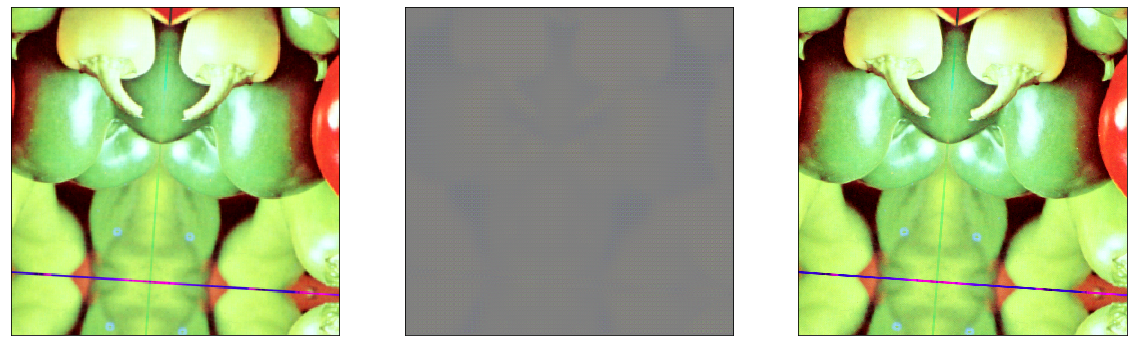

test_loss: 0.5018359422683716


In [0]:
#load checkpoint & compile the generator network
print('trying to load last saved weights...', end = ' ')
try:
    generator.load_weights('superresolution_deeper_net_weights')
    print('success.')
except:
    print('failed')
    pass

generator.compile(optimizer = Adam(gen_lr), loss = 'mae')

# Train generator
def logging(epoch, logs):
    if epoch % logging_steps == 0:
        testX, testY = get_batch(1, height_lr, width_lr, channels)
        clear_output()
        print('epoch', real_epoch + 1, '/', epochs, '--> step', epoch, '/', steps_per_epoch, ': loss', logs['loss'])
        testZ = generator.predict(testX)
        show([testX, testZ, testY])
        print('test_loss:', generator.evaluate(testX, testY, verbose = 0))
logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: logging(epoch, logs)
)
for real_epoch in range(epochs):
    X, Y = get_batch(batch_size, height_lr, width_lr, channels)
    generator.fit(X, Y, batch_size, epochs = steps_per_epoch, verbose = 0, callbacks = [logging_callback], shuffle = True)
    try:
        print('trying to save weights...', end = ' ')
        generator.save_weights('superresolution_deeper_net_weights')
    except:
        print('failed.')

### validate on complete picture

In [0]:
# show image in actual size https://stackoverflow.com/a/42314798/
def display_image_in_actual_size(im_data):
    dpi = 100
    height, width, depth = im_data.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')
    plt.show()

In [0]:
from PIL import Image
img = np.array(Image.open('./Set14/lenna.png'))
img = img /127.5 -1
x = inputs = Input(shape = img.shape)
x = Conv2D(32, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = Conv2D(3, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = fast_normalization(x)
x = upsample(x)
x = upsample(x)
generator = Model(inputs = inputs, outputs = x)
print('trying to load last saved weights...', end = ' ')
try:
    generator.load_weights('superresolution_deeper_net_weights')
    print('success.')
except:
    print('failed')
    pass
predicted = generator.predict(np.expand_dims((img), 0))
print('ground truth:')
img = (img + 1) * 127.5
display_image_in_actual_size(img.astype(np.uint8))
print('superresolution:')
predicted = np.squeeze(predicted)
predicted = (predicted + 1) * 127.5
display_image_in_actual_size(predicted.astype(np.uint8))
predicted = Image.fromarray(predicted.astype(np.uint8))
print('trying to save image as \'superresolution_deeper_net_result.png\'...', end = ' ')
try:
    predicted.save('superresolution_deeper_net_result.png', "PNG")
    print('success.')
except:
    print('failed.')
    pass